In [157]:
import time
import tensorflow as tf;
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tf.random.set_seed(100)

# Chargement de la base de données

In [158]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data.
x_train = x_train.astype('float32') /255.0
x_test = x_test.astype('float32') /255.0

x_train = np.reshape(x_train, (-1,28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)



# Lenet 5

In [159]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation=tf.nn.relu6, input_shape=(28,28,1), trainable=True, kernel_regularizer='l2'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation=tf.nn.relu6 , trainable=True, kernel_regularizer='l2'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation=tf.nn.relu6,  trainable=True),
    tf.keras.layers.Dense(units=84, activation=tf.nn.relu6, trainable=True),
    tf.keras.layers.Dense(units=10, activation='softmax')

]);
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_26 (Avera  (None, 12, 12, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_27 (Avera  (None, 4, 4, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_13 (Flatten)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 120)             

# Objet Quantizer

In [160]:
class Quantizer:
    def __init__(self, model):
        
        # attributs liés au model
        self.model = model
        self.layers = model.layers
        self.weights = []
        self.quantized_weights = None
        self.nb_bits = 8
        
        # scale dict
        self.scale_factor = {}
        self.activation_scale = {}
        
        
        
    def compile(self,optimizer, loss_fn, metric):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_metric = metric
        self.scales = np.zeros(len(self.model.layers) )
        
        
        
    def quantize_w(self, layer):
        if "conv"in layer.name or "dense" in layer.name:
            # getting kernel or weights values
            ow = layer.get_weights()[0]
            original_shape = layer.get_weights()[0].shape

            # vectorisation de la matrice de poids
            w = np.reshape(ow, (-1))

            # calculer l'espace des valeurs
            a = np.min(w)
            b = np.max(w)
            
            clamp_w = np.minimum(np.maximum(w, a), b)
            scale = (b - a)/(2**self.nb_bits - 1)
            self.scale_factor[layer.name] = scale
            

            # calcul des valeurs quantifiées
            q = np.rint((clamp_w -a)/scale ) * scale + a
            q = np.reshape(q,original_shape)

            # Appliquer les nouveaux poids
            layer.set_weights([q, layer.get_weights()[1]])

        
        
    def quantize_activation(self, layer, data, epoch):
        if epoch < 5:
          # calcul de la sortie de la couche
          output = layer(data, training = True)

          
          activation = tf.reshape(output, (data.shape[0], -1 ))
          a = tf.math.reduce_min(activation)
          b = tf.math.reduce_max(activation)
          
          # collecter les observations
          self.EMA.append(b-a)


          return output

        else:
          activation = layer(data, training = True)
          orig_shape = activation.shape

          # vectorisation
          activation = tf.reshape(activation, (data.shape[0], -1 ))

          a = tf.math.reduce_min(activation)
          b = tf.math.reduce_max(activation)
          clamp_w = tf.math.minimum(tf.math.maximum(activation, a), b)

          # Calcul des EMA
          ema = ( (b-a) * (1/101) ) + (np.mean(self.EMA[-101:-1])* (1 - (1/101))   )
          

          self.EMA.append(ema)
          
          scale = (ema)/(2**self.nb_bits - 1)
            # register activation scale
          self.activation_scale[layer.name] = scale


          # calcul des valeurs quantifiées
          q = tf.math.rint( (clamp_w - a)/scale )*scale + a
          q = tf.reshape(q, orig_shape)
          
          return q
    
    
    def train(self,x_train, y_train, val_data, val_labels, epochs = 100, batch_size= 32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.EMA = []
        
        # training history storage
        accur = []
        L = []
        
        # validation history storage
        v_accur = []
        v_loss = []

        if x_train.shape[0] % batch_size == 0:
            nb_train_steps = x_train.shape[0] // batch_size
        else:
            nb_train_steps = (x_train.shape[0] // batch_size) + 1
        # Training Loop
        for epoch in range(epochs):
            print(f"Epoch ({epoch +1 }/{epochs})")
            for i in range(nb_train_steps):
                # Batching data
                x = x_train[i*batch_size:(i+1)*batch_size]
                y = y_train[i*batch_size:(i+1)*batch_size]
                
                x = tf.constant(x)
                y = tf.constant(y)
                
                with tf.GradientTape() as tape:
                    # Forward pass
                    for layer in self.layers: 
                        # Quantifier les poids
                        self.quantize_w(layer)
                        # Quantifier les activation
                        x = self.quantize_activation(layer, x, epoch)
                    # calcul de la loss
                    loss = self.loss_fn(y, x)
                # Calcul du gradient
                grads = tape.gradient(loss, self.model.trainable_weights)
                

                # Decente de gradient
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                
                # Update training metric.
                self.acc_metric.update_state(y, x)
                train_acc = self.acc_metric.result()
                
                print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(train_acc),  loss), end='\r')
            print("\nValidation Step :")
            val_accur, val_loss = self.test(val_data, val_labels)
                
            accur.append(float(train_acc))
            L.append(loss)
            
            v_accur.append(val_accur)
            v_loss.append(val_loss)
            print("")
        return (accur, L, v_accur, v_loss)  

        
    def test(self,data, labels):
        accur = []
        l = []
        if data.shape[0] % self.batch_size == 0:
            nb_test_steps = data.shape[0] // self.batch_size
        else:
            nb_test_steps = (data.shape[0] // self.batch_size) + 1
        for layer in self.layers:
            self.quantize_w(layer)
            
        for i in range(nb_test_steps):
            # Batching data
            x = data[i*self.batch_size:(i+1)*self.batch_size]
            y = labels[i*self.batch_size:(i+1)*self.batch_size]

            x = tf.constant(x)
            y = tf.constant(y)
            for layer in self.model.layers:
                x = layer(x)

            # calcul de la loss
            loss = self.loss_fn(y, x)
            # calcul de l'accuracy
            self.acc_metric.update_state(y, x)
            test_acc = self.acc_metric.result()
            print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(test_acc),  loss), end='\r')
                
            accur.append(float(test_acc))
            l.append(float(loss))
        print("")        
        print("Accuracy Moy : {:.4f} ; loss Moy: {:.4f}" .format(np.mean(accur), np.mean(l) ))
        
        return (np.mean(accur), np.mean(l))
    
    def Post_quantization(self):
        w_tab = []
        for layer in Q.model.layers:
            if "conv"in layer.name or "dense" in layer.name:
                # Quantizing weights to int8
                scale = self.scale_factor[layer.name]
                w = layer.get_weights()[0]
                wq = np.rint( (w/scale)) 
                wq = np.minimum(np.maximum(-127,wq), 127)

                # Quantizing bias to int32
                bias = layer.get_weights()[1]
                scale_acti = self.activation_scale[layer.name]
                biasq = np.rint( (bias/(scale * scale_acti))) 
                
                
                # Ajouter au tableau de poids quantifiés
                w_tab.append(wq.astype("int8"))
                w_tab.append(biasq.astype("int32"))
                
                
                
        return w_tab

In [161]:
# Instanciation de l'objet
Q = Quantizer(model)

# Paramètre d'entrainement
Q.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1),
         loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         metric = tf.keras.metrics.SparseCategoricalAccuracy(),
)

In [162]:
# Entrainement         
accur, loss, val_accur, val_loss = Q.train(x_train, y_train, 
                                           x_test, y_test, 
                                           epochs = 10, 
                                           batch_size= 512 )        

Epoch (1/10)
Accuracy: 0.5725 ; loss: 0.5018
Validation Step :
Accuracy: 0.6076 ; loss: 0.8656
Accuracy Moy : 0.5910 ; loss Moy: 0.5625

Epoch (2/10)
Accuracy: 0.7425 ; loss: 0.3315
Validation Step :
Accuracy: 0.7522 ; loss: 0.6751
Accuracy Moy : 0.7475 ; loss Moy: 0.3895

Epoch (3/10)
Accuracy: 0.8061 ; loss: 0.2557
Validation Step :
Accuracy: 0.8115 ; loss: 0.5003
Accuracy Moy : 0.8089 ; loss Moy: 0.2547

Epoch (4/10)
Accuracy: 0.8414 ; loss: 0.2273
Validation Step :
Accuracy: 0.8449 ; loss: 0.4003
Accuracy Moy : 0.8432 ; loss Moy: 0.1967

Epoch (5/10)
Accuracy: 0.8642 ; loss: 0.2081
Validation Step :
Accuracy: 0.8664 ; loss: 0.3786
Accuracy Moy : 0.8654 ; loss Moy: 0.1807

Epoch (6/10)
Accuracy: 0.8772 ; loss: 0.1977
Validation Step :
Accuracy: 0.8787 ; loss: 0.3786
Accuracy Moy : 0.8779 ; loss Moy: 0.1807

Epoch (7/10)
Accuracy: 0.8863 ; loss: 0.1973
Validation Step :
Accuracy: 0.8875 ; loss: 0.3786
Accuracy Moy : 0.8869 ; loss Moy: 0.1807

Epoch (8/10)
Accuracy: 0.8932 ; loss: 0.1

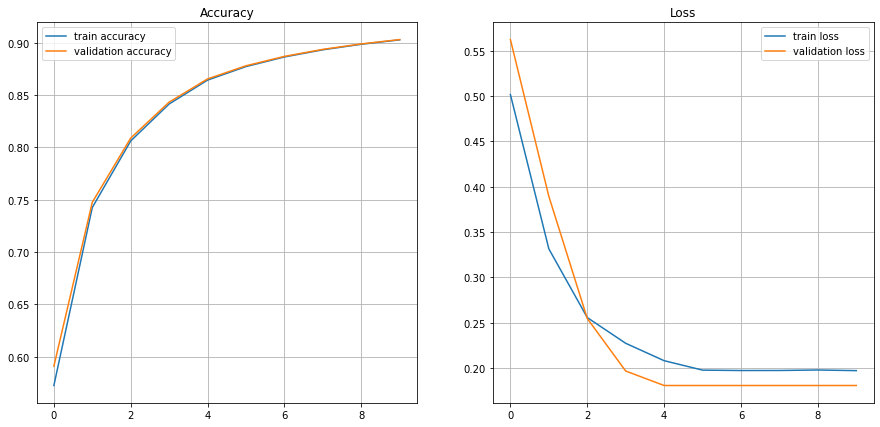

In [163]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(accur, label = "train accuracy")
plt.plot(val_accur, label = "validation accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(loss, label = "train loss")
plt.plot(val_loss, label = "validation loss")
plt.title("Loss")
plt.grid()
plt.legend()



#plt.savefig("sgd_lr_0.1_seed_100.png")
plt.show()


## Post Quantization

In [164]:
quantized_w = Q.Post_quantization()


## Test step with int weights

In [165]:
Q.test(x_test, y_test)

Accuracy: 0.9038 ; loss: 0.3786
Accuracy Moy : 0.9035 ; loss Moy: 0.1807


(0.9034895837306977, 0.180741398409009)

In [168]:
quantized_w

[array([[[[ 19,  22, -11,  -8, -49,  -2]],
 
         [[127,  64, -15,   1, -28,   6]],
 
         [[ 56,  14, -37, -57, -52,  71]],
 
         [[-16,  57, -16,  12,  91,  26]],
 
         [[  6,  44,  15, -45,  46,  32]]],
 
 
        [[[ 97,  47,  34,  63, -60, -44]],
 
         [[127,  70, -39,   0,  12,  32]],
 
         [[127,  42,   0, 119, -18,  27]],
 
         [[ 65, -31,  21,  21,  76, -70]],
 
         [[ -8, -10,  40, -52,  71, -25]]],
 
 
        [[[127,  39,  27,  36,  53, -28]],
 
         [[ 91, -33,  54, 127,  68,  -6]],
 
         [[ 79, -33, -31,  59,  63, -49]],
 
         [[115,   3,  23,  73, 113,  -5]],
 
         [[118, -23, -48,  72,  41, -29]]],
 
 
        [[[127,  39,  33, 126, -55,  43]],
 
         [[127, -18, -42, 127,  93,  29]],
 
         [[ 72, -71, -20, 127, 109, -40]],
 
         [[ 54, -37,  50, 127, 105,  -6]],
 
         [[ 34,  41, -51,  85, 127,  28]]],
 
 
        [[[ 61, -24,  -1, 127,  52,  38]],
 
         [[ 75, -48, 106, 127, -13,  53]],
